In [1]:
# general imports usually needed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8) # set default figure size, 8in by 6in

In [2]:
# the following is supposed to improve performance for sklearn SVC classifiers
# significantly if done before we import sklearn objects
# Discussion/description here: https://medium.com/intel-analytics-software/from-hours-to-minutes-600x-faster-svm-647f904c31ae
from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# libraries/classes more specific to this assignment gathered in
# one place so that we are sure all needed imports are done before
# needed
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [4]:
# notebook wide settings to make plots and numpy output more readable and visually easier to understand
np.set_printoptions(suppress=True)

#%matplotlib widget
#%matplotlib inline

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=14)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # default figure size if not specified in plot
plt.style.use('seaborn-darkgrid')

# Assignment 05: Ensemble Learning and Random Forests

**Due Date:** Friday 11/25/2022 (by midnight)


## Introduction 

In this assignment you will use the MNIST data set to create some ensemble classifiers.  This assignment
is a bit more open ended than some of the previous ones.  So try and create classifiers for submission
that do the tasks as described and are performing relatively well to classify the MNIST digits dataset.

## Part 1: Load and Setup MNIST data

Load the MNIST data set that we have used before, and split it into a training set,
a validation set, and a test set.  Use 50,000 instances for training, 10,000 for validation
and 10,000 for testing.  Be careful that the data is shuffled, e.g. that you have all 10 
digits in about equal proportions in the training, validation and test data sets.

We have sometimes had issues with the `fetch_openml()` method from `sklearn` we use below.  As a reminder, if
needed, you can download the csv file we use here by hand ald us pandas to load it in:

https://datahub.io/machine-learning/mnist_784

In [5]:
# download the csv file from the web and read it in as shown below if needed, if the fetch_openml() is not
# working in current version of sklearn
#mnist = pd.read_csv('../../data/mnist_784.csv')
#X, y = mnist['data'], mnist['target']
#y = y.astype(np.uint8) # convertes to an integer using 8 bits, but we only need 4 bits here

In [6]:
# there is a bug in fetch_openml where it does not cache the data it downloads.  This is better than before, at least it works,
# but we can force downloaded data to be cached to tmp directory so that at least if rerunning notebooks the next doesn't take too long
import joblib
from sklearn.datasets import fetch_openml
from joblib import memory
memory = joblib.Memory('../data/tmp')
fetch_openml_cached = memory.cache(fetch_openml)

In [7]:
mnist = fetch_openml_cached('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

The data is shuffled if you use `fetch_opemnl()`, though that might not always
be the case.  For example, looking at the target labels of the first 10 items we
see:

In [8]:
print(mnist.target[:10])

[5 0 4 1 9 2 1 3 1 4]


So we could simply split up the data and targets by hand as asked for
here.  But instead we show using `train_test_split()` in 2 steps.
We first split out 10,000 items for the ultimate test set.

We are using the `random_state` parameter for most of the functions in
this example solution to make the results more reproducable.  Using
a `random_state` of 42 here insures that all 3 of our train, validation
and test sets are always split the same way when this notebook is run.

In [9]:
# we end up with 10,000 in the test set and rest in train_val
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)

We then perform anohter split on the remaining 60,000
values, so that we end up with 50,000 items for basic training,
and a 10,000 sized validation set.

In [10]:
# now split remaining to get 10,000 for validation and remaining 50,000 for training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [11]:
# demonstrate we got expected sizes from the splits
print(X_test.shape)
print(y_test.shape)

print(X_val.shape)
print(y_val.shape)

print(X_train.shape)
print(y_train.shape)

(10000, 784)
(10000,)
(10000, 784)
(10000,)
(50000, 784)
(50000,)


As a reminder, here are the first 100 digits in our
training data set, their labels and corresponding digit images.

In [12]:
def plot_digits(samples, images_per_row=10, **options):
    """Plot a set of MNIST samples.  
    """
    size = 28
    images_per_row = min(len(samples), images_per_row)
    images = [instance.reshape(size,size) for instance in samples]
    n_rows = (len(samples) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(samples)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

[[4 4 7 0 8 4 8 0 7 9]
 [3 9 4 5 4 2 7 1 4 3]
 [0 5 7 6 1 2 3 9 0 8]
 [3 9 6 3 3 3 7 6 9 1]
 [0 3 5 9 0 1 8 9 0 3]
 [4 6 6 5 3 0 7 1 7 8]
 [8 4 1 2 6 7 6 6 7 5]
 [6 3 3 4 3 0 0 1 9 7]
 [8 2 5 9 1 3 8 1 9 1]
 [9 7 9 4 3 5 9 3 2 5]]


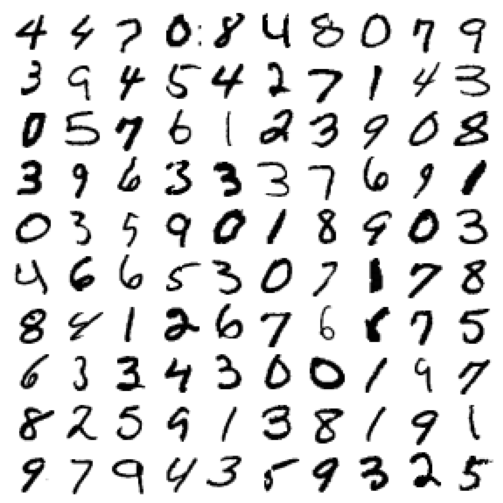

In [13]:
plt.figure(figsize=(9,9))

# display the first 100 MNIST digits
example_images = X_train[:100]
plot_digits(example_images, images_per_row=10)

# display the labels of these digits
print(y_train[:100].reshape((10,10)))

## Part 2: Train Classifiers on MNIST training data

**Instructions**:

Train the following 3 types of classifiers on this MNIST training dataset:

1. Random Forest classifier
2. Extra-Trees classifier
3. SVM classifier.

Try and tune these so they each work well individually well.  Show performance of each of the 3 on the validation set, e.g. report a confusion matrix and raw accuracy for each of the 3 classifiers on validation data.

First lets just do as asked for here.  It is easy to find random forest and extra tree classifiers that give greater than 95% accuracy on 
validation data when trained with the 50,000 sized training set.

We first shows training these two classifiers using 1000 decision tree estimators for each.  We again specify the `random_state` here for all
of our classifiers to enhance reproducability of this example solution.

In [14]:
# random forest classifier using all defaults, this causes a tree with 100
# estimators of unlimited depth
random_forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# fit the classifier on the training data
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

Since we allow unlimited depth, this random forest should give a perfect
accuracy score on the data we trained with.

In [15]:
random_forest_clf.score(X_train, y_train)

1.0

However hopefully students realize that we want a report of the performance on
the held back validation data.  The raw accuracy and confusion matrix for this
classifier on unseen validation data gives us:

In [16]:
random_forest_clf.score(X_val, y_val)

0.9713

In [17]:
y_pred = random_forest_clf.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[ 988,    0,    0,    0,    0,    1,    1,    0,    6,    1],
       [   0, 1136,    6,    1,    1,    2,    3,    4,    3,    2],
       [   5,    3,  981,    3,    2,    0,    2,    4,    6,    1],
       [   2,    0,    8,  981,    0,   12,    2,   11,    8,    4],
       [   2,    1,    2,    0,  941,    0,    3,    1,    3,   13],
       [   5,    0,    0,    8,    4,  852,    6,    2,    3,    5],
       [   1,    4,    1,    0,    0,    7,  931,    0,    1,    0],
       [   0,    2,   11,    1,    7,    0,    0, 1036,    2,   11],
       [   3,    2,    4,    5,    6,    9,    4,    0,  947,    8],
       [   1,    1,    3,    8,    9,    3,    0,    6,    5,  920]])

We will get above 96% accuracy on the validation data with the default
parameters for the random forest.

Here then is the same but for an Extra (Extremely Random) Trees classifier.
You will get about the same results using the default parameters for an
Extra Trees classifier:

In [18]:
# random forest classifier using all defaults, this causes a tree with 100
# estimators of unlimited depth
extra_trees_clf = ExtraTreesClassifier(random_state=42, n_jobs=-1)

# fit the classifier on the training data
extra_trees_clf.fit(X_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=42)

In [19]:
# performance on training data should be perfect for a forest/extra tree if
# we don't regularize it in anyway
extra_trees_clf.score(X_train, y_train)

1.0

In [20]:
# performance on unseen validation data should be about the same as
# we saw for the random forest
extra_trees_clf.score(X_val, y_val)

0.9715

In [21]:
y_pred = extra_trees_clf.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[ 987,    0,    1,    1,    0,    2,    4,    0,    2,    0],
       [   0, 1137,    8,    1,    1,    2,    1,    3,    4,    1],
       [   6,    1,  977,    3,    3,    2,    2,    5,    7,    1],
       [   1,    0,   10,  982,    0,   16,    0,   11,    4,    4],
       [   1,    1,    1,    0,  938,    1,    4,    1,    4,   15],
       [   4,    0,    0,    9,    3,  855,    6,    2,    2,    4],
       [   1,    3,    1,    0,    1,    4,  935,    0,    0,    0],
       [   0,    3,   13,    1,    6,    0,    0, 1035,    0,   12],
       [   1,    1,    3,    8,    6,   10,    3,    0,  949,    7],
       [   2,    1,    3,    8,   10,    3,    0,    6,    3,  920]])

I get an above 97% accuracy for the Extra Trees classifier, so slightly
better.  But it is hard to say if actually better, may be simply a product
of the train/validation data split, e.g. the random forest might do better on
unseen data sometimes if it were split differently.

Training a support vector machine is more difficult.
**WARNING**: The following may take quite a bit of time to train/converge
depending on your system.  Later we will limit the maximum number of
iterations and/or convergence tolerance of the SVM classifier when we build
an ensemble.

You should find that, unlike before, the SVM classifier won't give perfect
accuracy on the training data.  This is expected, the SVM classifier works
differently than the tree ensembles.  It is fitting a nonlinear decision
boundary(ies) to the data, so it is difficult to get a perfect fit.

But you will probably find that the raw SVM classifier performs the best of the
3 classifiers demonstrated here on the validation data (though it is unclear
if it is actually better or just slightly better on this particular
train/validation split).

In [22]:
# create a support vector machine classifier using default radial basis
# kernel.  We limit max iterations
svm_clf = SVC(random_state=42)

# fit the classifier on the training data
svm_clf.fit(X_train, y_train)

SVC(random_state=42)

In [23]:
svm_clf.score(X_train, y_train)

0.98938

In [24]:
# performance on unseen validation data should be about the same as
# we saw for the random forest
svm_clf.score(X_val, y_val)

0.9788

In [25]:
y_pred = svm_clf.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[ 988,    0,    2,    0,    0,    2,    2,    0,    2,    1],
       [   0, 1143,    7,    0,    1,    0,    0,    2,    4,    1],
       [   0,    2,  988,    1,    1,    1,    3,    4,    6,    1],
       [   2,    2,    6,  990,    0,   14,    0,    5,    7,    2],
       [   0,    1,    2,    0,  948,    0,    5,    1,    0,    9],
       [   2,    0,    0,    5,    5,  867,    2,    1,    0,    3],
       [   2,    2,    2,    0,    1,    4,  934,    0,    0,    0],
       [   0,    3,    7,    1,    6,    0,    0, 1044,    1,    8],
       [   1,    3,    3,    7,    4,    4,    3,    1,  959,    3],
       [   1,    1,    0,    4,   11,    1,    0,    9,    2,  927]])

## Part 3: Create an Ensemble

Next combine your 3 classifiers into an ensemble (using scikit-learn enesmble methods
as shown in our textbook).  See if you can create an ensemble that outperforms each
individual classifier on the validation set, using soft or hard voting.  

Once you have found an ensemble that performs better than the individual classifiers (or at least
no worse), evaluate it on the test set.  Give raw accuracy and a confusion matrix of the results on
validation and test data.  How much better does it perform compared to individual classifiers?

### Hard Voting Ensemble

In the following we will demonstrate creating an ensemble on a slightly
different set of classifiers.  It is ok if you just used the classifiers
you had before.  But most likely you will find that you don't really getting any
performance from ensembling the 3 asked for classifiers if they have performance
about 96% to 97%.  It would probably be difficult to get much of a significant
improvement unless we had many more classifiers in the ensemble and they were
quite a bit different.

Instead lets retrain the classifiers, but I am going to use some regularization,
especially on the tree classifiers.  The tree classifiers especially shown in
part 2 are probably overfit on the data.  Some regularization might actually help
improve performance on validation/test data.

Here we again create a random forest, extra tree and SVM classifier.
However, we are going to limit all 3 of them and add in some regularization.
We are doing this more for the purpose of showing that it is possible to
use ensemble voting to improve performance a significant amount over
the individual members of the ensemble.

Also since you were asked to create a voting ensemble, we demonstrate declaring
and fitting all of the individual estimators at once in the voting ensemble.

In [26]:
# retrain the classifiers.  Use max_depth to regularize the trees
# quite a bit.  We also increase C and use max_iterations to speed up the
# training time of the svm classifier, and regularize it more as well.
random_forest_clf = RandomForestClassifier(max_depth=5, random_state=42, n_jobs=-1)
extra_trees_clf = ExtraTreesClassifier(max_depth=5, random_state=42, n_jobs=-1)
svm_clf = SVC(C=0.5, max_iter=100, random_state=42)

In [27]:
# instead of fitting indiviually, add estimators into a
# voting classifier, and fit all together
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(max_depth=5, n_jobs=-1,
                                                     random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(max_depth=5, n_jobs=-1,
                                                   random_state=42)),
                             ('svm_clf',
                              SVC(C=0.5, max_iter=100, random_state=42))])

First here is the raw performance (accuracy) now of the individual trained
estimators on the training data they were trained with.

In [28]:
[estimator.score(X_train, y_train) for estimator in voting_clf.estimators_]

[0.86452, 0.8346, 0.98156]

The result here will be that all 3 classifiers performance has decreased.  The tree
classifiers especially no longer will get perfect accuracy, since we regularize them
to stop at a depth of 5.  The SVM classifier is significanly better on the test
data now, even though we limited convergence and added in a smaller `C` to get
more regularization.

As asked for, lets check the individual performance on the validation data,
and then the ensemble performance on the validation data.  We are using hard
voting here when we check the ensemble performance, since we didn't specify to use
soft voting when creating the voting classifier.

In [29]:
# individal estimator performance on the unseen validation data
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.863, 0.8322, 0.974]

In [30]:
# ensemble performance on unseen validation data using hard voting
voting_clf.score(X_val, y_val)

0.8871

In [31]:
# confusion matrix performance on unseen validation data of the ensemble
y_pred = voting_clf.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[ 979,    0,    2,    1,    0,    0,    7,    2,    6,    0],
       [   0, 1138,    4,    1,    1,    2,    4,    2,    5,    1],
       [  21,   29,  899,    9,    6,    0,   14,   21,    6,    2],
       [  14,   30,   25,  883,    0,   17,    3,   24,   11,   21],
       [   7,    8,    8,    1,  871,    0,    9,    7,    8,   47],
       [  33,   37,    3,  126,   34,  587,   17,    5,    7,   36],
       [  10,   15,    8,    2,    6,    5,  894,    3,    2,    0],
       [   1,   31,   20,    3,   11,    0,    0,  984,    5,   15],
       [   4,   55,   15,   40,   12,    7,   12,    6,  810,   27],
       [  10,   12,    9,   16,   31,    1,    3,   38,   10,  826]])

You will see we still haven't quite illustrated what we would like to yet.
The overall ensemble performance is probably not as good as that achieved by
the SVM classifier by itself on the validation data.


### Soft Voting Ensemble

As a final example, lets try again but use soft voting to see if that helps.
To perform soft voting we will need to enable the calculation of
target probabilities for the SVM classifier when we (re)train it.
This will cause additional slow down of the training, as some students found out.
We will need to limit `max_iterations` and maybe also specify a more tolerant
`tolerance` for the SVM classifier to get it to finish training in a reasonable
amount of time.


In [32]:
# retrain the classifiers. Same as before, adding in regularization.
# but also enable calculation of target probabilities for the SVM
# classifier to allow for soft voting
random_forest_clf = RandomForestClassifier(max_depth=5, random_state=42, n_jobs=-1)
extra_trees_clf = ExtraTreesClassifier(max_depth=5, random_state=42, n_jobs=-1)
svm_clf = SVC(C=0.5, max_iter=100, probability=True, random_state=42)

In [33]:
# instead of fitting indiviually, add estimators into a
# voting classifier, and fit all together
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
]

# use soft voting this time since svm classifier supports target probabilities
voting_clf = VotingClassifier(named_estimators, voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(max_depth=5, n_jobs=-1,
                                                     random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(max_depth=5, n_jobs=-1,
                                                   random_state=42)),
                             ('svm_clf',
                              SVC(C=0.5, max_iter=100, probability=True,
                                  random_state=42))],
                 voting='soft')

In [34]:
# performance of estimators on the data trained with
[estimator.score(X_train, y_train) for estimator in voting_clf.estimators_]

[0.86452, 0.8346, 0.98156]

In [35]:
# individal estimator performance on the unseen validation data
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.863, 0.8322, 0.974]

In [36]:
# ensemble performance on unseen validation data using hard voting
voting_clf.score(X_val, y_val)

0.9716

In [37]:
# confusion matrix performance on unseen validation data of the ensemble
y_pred = voting_clf.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[ 986,    0,    2,    0,    0,    3,    3,    0,    2,    1],
       [   0, 1141,    7,    1,    1,    0,    0,    1,    5,    2],
       [   3,    5,  978,    2,    2,    1,    3,    5,    7,    1],
       [   3,    2,   11,  977,    1,   14,    1,    7,    8,    4],
       [   1,    1,    2,    0,  945,    0,    6,    2,    0,    9],
       [   3,    5,    0,    6,    6,  856,    5,    1,    0,    3],
       [   2,    4,    3,    0,    1,    4,  930,    0,    1,    0],
       [   0,    5,    9,    3,    6,    0,    0, 1036,    2,    9],
       [   1,   11,    4,    6,    6,    4,    3,    1,  948,    4],
       [   2,    1,    1,    5,   12,    1,    0,   12,    3,  919]])

We should get the same individual performance as before. However,
previously, the performance on the validation data of the voting ensemble
using hard voting was an accuracy of 0.877.  There may be a slight improvement
with soft voting, but again I wouldn't want to state this definitively as it may
be an artifact of the train/validation split.

One interesting thing to note in the confusion matrix.  Some classes look pretty
close to perfect for the soft voting (e.g. first two columns.  while other
digits seem to have lots of problems (last column).  It seems to me that
some digits have improved at the cost of others getting worse here.

## Part 4: Create a Blender Stacking Ensemble

Run the individual classifiers from the previous exercise to make predictions
on the validation set, and create a new training set with the resulting
predictions: each training instance is a vector containing the set of predictions
from all your classifiers for an image, and the target is the image’s class. Train
a classifier on this new training set. Congratulations, you have just trained a
blender, and together with the classifiers it forms a stacking ensemble! Now
evaluate the ensemble on the test set. For each image in the test set, make
predictions with all your classifiers, then feed the predictions to the blender to
get the ensemble’s predictions. How does it compare to the voting classifier
you trained earlier?

### Hard Prediction Blender

We will first use the 3 regularized classifiers and do a blender using the
predicted target class.

I won't retrain again the ensemble estimators.  We can use the previously 3
trained estimators from the ensemble. 

First of all we need to create a new set of training data by hand.  We want to get the
predictions for each of the 3 trained previous estimators on the validation data.
Note we create a new set of `X` inputs with 3 columns here, where each column
holds the prediction for a sample from each of the 3 estimators.

In [38]:
estimators = voting_clf.estimators_

In [39]:
# now create a new set of inputs using the prediction outputs from all 3 of these estimators
# We have an empty array for the X inputs of shape (10,000, 3) where we will gather and hold the
# predictions of the estimators we are going to blend
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

# fill in the empty array
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

Here is the resulting new inputs we will use as the input for a new blender/estimator.  Notice that each of the 3
columns contains the predicted target from each of our 3 trained estimators respectively.

In [40]:
# basically each column is the prediction from each of the 3 classifiers we have trained so far, on each of the 10,000 validation digits
print(X_val_predictions.shape)

print(X_val_predictions[:10,:])

(10000, 3)
[[9. 9. 5.]
 [8. 8. 8.]
 [1. 1. 2.]
 [4. 4. 4.]
 [4. 4. 4.]
 [2. 2. 2.]
 [5. 5. 5.]
 [9. 9. 9.]
 [4. 9. 4.]
 [4. 4. 4.]]


As an example, we will use a Random Forest classifier again to be the blender/estimator here.  We could use any type of classifier we have
talked about before to train as the blender/estimator.  It may increase performance significantly using some other classifier method here
(I did not try out any others, so there may be room for improvements here).

We will create a random forest with twice as many estimators as before.  We again don't limit the
depth or do regularization here, so this estimator may tend to get overfit.

Notice that we ask for the `oob_score` to be calculated here. We
discussed this briefly in class, this uses out-of-bag samples to
estimate the generalization score.  So while we will test
with the test data next, this is also an indication of how well
this blender might perform on unseen data, e.g. how well it
can generalize.

Notice that we simply use the original `y_val` target labels here,
which is what we want.  We created a new set of input for this
blender, using the predictions from the first stage classifiers.
But the targets are the same as we originally need the blender
to learn to predict.

In [41]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42, n_jobs=-1)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

Since we asked for `oob_score` to be calculated, we can get this.
This should be a good proxity of the accuracy we will see on unseen
test data.

In [42]:
rnd_forest_blender.oob_score_

0.9707

We only got 87 or 88% accuracy with the hard/soft voting classifier previously.  This is probably a
significant improvement in performance here, we have a 4% jump over best we saw with simple voting
ensembles.

But lets check the results with completely unseen test data to be sure.  Up to this point we have
never used the `X_test` data in any evaluation.

But the `X_test` data has `28x28` inputs, where the blender expects 3 inputs.  So we first again
have to create the actual test data using predictions from the state 1 classifiers, before we
can feed that to our trained blender/estimator.

The procedure is the same as before.  Create an array to hold the predictions from our 3
stage 1 estimators, but from making predictions on the `X_test` data this time.

In [43]:
# generate input data for the blender, but this time on the X_test data that neither the stage 1
# estimators, nor the stage 2 blender/estimator have never seen
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

# get predictions from all estimators gathered into this new set of X inputs
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [44]:
# generate predictions on this set of test prediction inputs
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [45]:
# raw accuracy on unseen test data
accuracy_score(y_test, y_pred)

0.9679

In [46]:
# confusion matrix of this blender/estimator on the unseen test data
confusion_matrix(y_test, y_pred)

array([[ 969,    1,    3,    0,    1,    1,    2,    1,    5,    0],
       [   0, 1137,    5,    4,    0,    0,    0,    3,    2,    1],
       [   0,    4,  940,    3,    2,    0,    5,    3,   10,    0],
       [   0,    2,   21,  976,    1,   13,    1,    6,   10,    4],
       [   1,    1,    2,    0,  878,    0,    4,    6,    2,   12],
       [   1,    1,    2,   15,    3,  904,    8,    1,    2,    0],
       [   1,    1,    0,    0,    5,    4,  945,    2,    3,    0],
       [   0,    6,   10,    0,    4,    0,    0, 1023,    2,   10],
       [   1,    4,   10,   10,    5,    7,    5,    5,  918,    4],
       [   6,    6,    1,    8,   11,    2,    1,    7,    5,  989]])

The result here mostly verifies that the `oob_score` is basically accurate in this case.  We still get 92%+ accuracy on
data that was never seen before by the stage 1 estimators nor the stage 2 blender/estimator.

### Soft Prediction Blender

As a final example, lets see if using the target probability estimates can improve performance of the stacking blender
approach here.

Again we have already trained our 3 stage 1 estimators, and we trained the SVM classifier to be able to estimate the
target probabilities.  So we simply need to do the same as we just did, but we want to use as inputs the target probabilities
instead of the simple predicted target class.  Thus since there are 10 target classes in this problem, we will end up with a
create input matrix with 30 columns, containing the 10 predicted probabilities from each of the 3 classes.

In the following cell we create the new set of inputs from our stage 1 estimators, but using the predicted probabilities
instead of the final predicted target class.

In [47]:
# now create a new set of inputs using the prediction outputs from all 3 of these estimators using the validation data
# notice that we have 3 * 10 columns now
X_val_predictions = np.empty((len(X_val), len(estimators) * 10), dtype=np.float32)

# fill in the predictions.  We do some calculations to determine the indexes to fill in.  Notice we
# are using the `predict_proba()` here now to get the target class probabilities.
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index * 10:(index+1)*10] = estimator.predict_proba(X_val)

Again just to be sure you understand what we have done, lets look at this alternative set of newly generated inputs.
These inputs have a shape of (10,000, 30).  We have 30 columns because we have predicted probabilities for each of the
10 output target classes from each of the 3 stage 1 estimators.

In [48]:
# basically each column is the prediction from each of the 3 classifiers we have trained so far, on each of the 10,000 validation digits
print(X_val_predictions.shape)


print(X_val_predictions[:10,:])

(10000, 30)
[[0.02       0.02       0.01       0.04       0.15       0.27
  0.04       0.07       0.02       0.36       0.05583551 0.06214771
  0.03912957 0.08606807 0.11840504 0.17523427 0.06582743 0.1327085
  0.07906535 0.18557854 0.         0.         0.         0.00000054
  0.         0.963305   0.         0.         0.03657724 0.00011723]
 [0.02       0.         0.15       0.11       0.04       0.12
  0.04       0.02       0.48       0.02       0.08347584 0.01582254
  0.15937899 0.18385121 0.05552633 0.11679689 0.06033066 0.01699853
  0.26215824 0.0456608  0.         0.         0.00027283 0.05543074
  0.         0.00000018 0.         0.         0.94429624 0.        ]
 [0.         0.51       0.29       0.1        0.         0.
  0.01       0.         0.09       0.         0.01791245 0.34733436
  0.2208282  0.1338368  0.01758008 0.0402458  0.05363156 0.02489688
  0.11841267 0.02532118 0.         0.00005608 0.9607097  0.00027536
  0.         0.         0.         0.         0.0389588

The remaining will be basically a copy of the steps before, but using inputs with the predicted class probabilities instead of the
single predicted class.

In [49]:
# recreate a random forest classifier with 200 estimators on this expanded set of input data
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42, n_jobs=-1)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [50]:
# estimate generalization performance from the `oob_score` as before
rnd_forest_blender.oob_score_

0.9746

I usually again see an even bigger improvement on the blender stacking performance here.  Performance jumps up to
95%+ accuracy.

But again, lets double check this by looking at performance for this blender ensemble using
the completely unseen test data as before.

In [51]:
# again we need a new set of inputs, but using the X_test data this time
X_test_predictions = np.empty((len(X_test), len(estimators)*10), dtype=np.float32)

# gather the predicted target probabilities from the estimators for the unseen test data
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index*10:(index+1)*10] = estimator.predict_proba(X_test)

In [52]:
# predictions of the blender on this test data input
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [53]:
# raw accuracy on unseen test data
accuracy_score(y_test, y_pred)

0.9709

In [54]:
# confusion matrix of this blender/estimator on the unseen test data
confusion_matrix(y_test, y_pred)

array([[ 970,    0,    3,    0,    1,    1,    2,    1,    4,    1],
       [   0, 1136,    5,    5,    0,    0,    0,    3,    2,    1],
       [   0,    4,  940,    3,    2,    1,    7,    3,    7,    0],
       [   0,    2,   11,  990,    1,   10,    2,    6,    6,    6],
       [   1,    1,    2,    0,  880,    0,    4,    4,    2,   12],
       [   1,    0,    1,   16,    0,  908,    8,    1,    2,    0],
       [   1,    1,    0,    0,    4,    5,  947,    0,    3,    0],
       [   0,    6,   10,    0,    4,    0,    0, 1023,    1,   11],
       [   1,    4,    8,   10,    4,    7,    5,    5,  921,    4],
       [   6,    6,    0,    8,    9,    1,    0,    8,    4,  994]])

## Conclusion

The blended ensemble on the target probabilities shows another increse of 2% or so over the blended ensemble using the simple
final predicted target.  Here you should take a step back and appreciate what we have done.  The individual classifiers in
this ensemble get raw accuracies from %83 to %90 or so.  So this blended ensemble is definitiely improving the performance over
the individual estimators.

Also if you recall, the simple hard and soft voting ensembles only achieved about the same or not as good of a result as the
best individual classifier in the ensemble.  So the stacked blender here is really doing something to boost performance.

But we shouldn't be too impressed.  As we showed in part 1, we can easily train individual good classifiers that achieve about 96 to
97% on this data (best NN / DNN classifiers will get above 99% accuracy on unseen test data).  

So while this example hopefully helps convince you that ensembles can improve performance, it is still a question if we could find
some stacking or blended ensemble that would improve on the best individual classifier performance here.